## Importando bibliotecas e o modelo
Os blocos abaixo temos todas as bibliotecas utilizadas e o modelo importado do arquivo E_Net.py, tome o cuidade para estar na mesma pasta desse arquivo notebook

In [1]:
#Importando módulos necessários
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import models
from torchsummary import summary
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [2]:
#Importando implementação da arquitetura da rede E-Net
from E_Net import ENet

## Leitura e organização do dataset
Por equanto estamos utilizando o dataset Cityscape, benchmark para a tarefa de segmentação semântica de cidades, disponibilizado em [cityscapes-dataset](https://www.cityscapes-dataset.com/). O dataset é dividido em imagens de cidades em que cada imagem real possui uma máscara correspondente com as labels de cada classe. Foi feito uma DTL (disponibilizada em ../data_processing/DTL_config.json) com o intuito de fazer um pré-processamento, como redimensionamento e mudanças das labels a fim de obter as imagens no formato necessário: 512x512 pixels e máscaras binárias contendo rua/estrada em branco e resto como classe neutra.

In [3]:
#Função utilizada para ler dataset
def load_dataset(data_path, grayscale):
    if grayscale is True:
        transf = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])
    else:
        transf = transforms.ToTensor()
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transf
    )
    return dataset

In [4]:
#Configurando caminhos para dataset

aachen_real_PATH = '../CityScapes_RoadDetection-dtl/aachen/real_img/'
aachen_mask_PATH = '../CityScapes_RoadDetection-dtl/aachen/masks_machine/'

dusseldorf_real_PATH = '../CityScapes_RoadDetection-dtl/dusseldorf/real_img/'
dusseldorf_mask_PATH = '../CityScapes_RoadDetection-dtl/dusseldorf/masks_machine/'

munster_real_PATH = '../CityScapes_RoadDetection-dtl/munster/real_img/'
munster_mask_PATH = '../CityScapes_RoadDetection-dtl/munster/masks_machine/'

ulm_real_PATH = '../CityScapes_RoadDetection-dtl/ulm/real_img/'
ulm_mask_PATH = '../CityScapes_RoadDetection-dtl/ulm/masks_machine/'

bremen_real_PATH = '../CityScapes_RoadDetection-dtl/bremen/real_img/'
bremen_mask_PATH = '../CityScapes_RoadDetection-dtl/bremen/masks_machine/'

lindau_real_PATH = '../CityScapes_RoadDetection-dtl/lindau/real_img/'
lindau_mask_PATH = '../CityScapes_RoadDetection-dtl/lindau/masks_machine/'

stuttgart_real_PATH = '../CityScapes_RoadDetection-dtl/stuttgart/real_img/'
stuttgart_mask_PATH = '../CityScapes_RoadDetection-dtl/stuttgart/masks_machine/'

In [5]:
#Carregando dataset das cidades
dataset_aachen_real = load_dataset(aachen_real_PATH, False)
dataset_aachen_mask = load_dataset(aachen_mask_PATH, True)
print("Quantidade de imagens - aachen: ",len(dataset_aachen_real))

dataset_dusseldorf_real = load_dataset(dusseldorf_real_PATH, False)
dataset_dusseldorf_mask = load_dataset(dusseldorf_mask_PATH, True)
print("Quantidade de imagens - dusseldorf: ",len(dataset_dusseldorf_real))

dataset_munster_real = load_dataset(munster_real_PATH, False)
dataset_munster_mask = load_dataset(munster_mask_PATH, True)
print("Quantidade de imagens - munster: ",len(dataset_munster_real))

dataset_ulm_real = load_dataset(ulm_real_PATH, False)
dataset_ulm_mask = load_dataset(ulm_mask_PATH, True)
print("Quantidade de imagens - ulm: ",len(dataset_ulm_real))

dataset_bremen_real = load_dataset(bremen_real_PATH, False)
dataset_bremen_mask = load_dataset(bremen_mask_PATH, True)
print("Quantidade de imagens - bremen: ",len(dataset_bremen_real))

dataset_lindau_real = load_dataset(lindau_real_PATH, False)
dataset_lindau_mask = load_dataset(lindau_mask_PATH, True)
print("Quantidade de imagens - lindau: ",len(dataset_lindau_real))

dataset_stuttgart_real = load_dataset(stuttgart_real_PATH, False)
dataset_stuttgart_mask = load_dataset(stuttgart_mask_PATH, True)
print("Quantidade de imagens - stuttgart: ",len(dataset_stuttgart_real))

Quantidade de imagens - aachen:  174
Quantidade de imagens - dusseldorf:  221
Quantidade de imagens - munster:  174
Quantidade de imagens - ulm:  95
Quantidade de imagens - bremen:  316
Quantidade de imagens - lindau:  59
Quantidade de imagens - stuttgart:  196


In [6]:
#Unindo datasets a fim de criar um dataset de treino e de validação
dataset_train_real = torch.utils.data.ConcatDataset([dataset_aachen_real,
                                               dataset_bremen_real,
                                               dataset_dusseldorf_real,
                                               dataset_stuttgart_real,
                                               dataset_ulm_real])

dataset_train_mask = torch.utils.data.ConcatDataset([dataset_aachen_mask,
                                               dataset_bremen_mask,
                                               dataset_dusseldorf_mask,
                                               dataset_stuttgart_mask,
                                               dataset_ulm_mask])

print("Dataset de treino: ", len(dataset_train_real), " imagens")

dataset_val_real = torch.utils.data.ConcatDataset([dataset_lindau_real,
                                               dataset_munster_real])

dataset_val_mask = torch.utils.data.ConcatDataset([dataset_lindau_mask,
                                               dataset_munster_mask])

print("Dataset de validação: ", len(dataset_val_real), " imagens")

Dataset de treino:  1002  imagens
Dataset de validação:  233  imagens


In [7]:
#Tamanho do lote de imagens a serem carregadas - para validação utilizamos 1
batch_size = 1

#Criando classes do tipo dataloader o qual retornará iterador das 
#imagens na formatação necessária

#Treino
dataloader_train_real = torch.utils.data.DataLoader( 
    dataset_train_real,
    batch_size=batch_size)

dataloader_train_mask = torch.utils.data.DataLoader( 
    dataset_train_mask,
    batch_size=batch_size)

#Validação 
dataloader_val_real = torch.utils.data.DataLoader( 
    dataset_val_real,
    batch_size=batch_size)

dataloader_val_mask = torch.utils.data.DataLoader( 
    dataset_val_mask,
    batch_size=batch_size)

## Carregando modelo
Iremos carregar o modelo a ser validado. Lembre de determinar o caminho do modelo a ser carregado

In [8]:
#Path do modelo a ser carregado
path_checkpoint_load = '../checkpoints_model/model1_2020-07-20.tar'

#Checo se GPU está disponível, se não irei permanecer trabalhando na CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
print(torch.cuda.get_device_name(device))

#Criando modelo e já passando para GPU
#Lembre de passar como parâmetro o número de canais para imagem gerada
E_Net_model = ENet(1).to(device)

import os
#Checando se o arquivo existe
if os.path.isfile(path_checkpoint_load):
    print("\nCarregando checkpoint de " + path_checkpoint_load)
    #Carregando informações salvas do modelo
    checkpoint_info = torch.load(path_checkpoint_load)
    epoch_ini = checkpoint_info['epoch']
    loss = checkpoint_info['loss']
    #Carregando modelo
    E_Net_model.load_state_dict(checkpoint_info['Model_state'])
        
    print('\n --- Loaded Model ---\nModel version: {}\noptimizer params: {}\ncriterion params: {}\nepoch: {}\nloss: {}\n'
          .format(checkpoint_info['Model_version'], checkpoint_info['optimizer_index'], checkpoint_info['criterion'] ,epoch_ini,loss))
else:
    print("Arquivo não encontrado !")

cuda
GeForce GTX 1050

Carregando checkpoint de ../checkpoints_model/model1_2020-07-20.tar

 --- Loaded Model ---
Model version: 1.0
optimizer params: Adam - lr = 0.0005
criterion params: BCELoss
epoch: 99
loss: 0.012657715938985348



In [9]:
#Passando modelo para modo de validação
#É importante para sinalizar para camadas de dropout e batchnorm congelarem
E_Net_model.eval()

ENet(
  (init_block): InitialBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (prelu): PReLU(num_parameters=16)
    (batchnorm): BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bottleneck10): DownsamplingBottleneck(
    (maxpooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (activation_function1): PReLU(num_parameters=1)
    (main_conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (activation_function2): PReLU(num_parameters=1)
    (conv2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

## Visualizando imagens geradas
Antes de aplicar métricas de validação iremos testar o modelo sobre algumas imagens, tanto do dataset utilizado no treinamento, como no dataset de validação, para observar o comportamento do modelo

In [10]:
#Criando iteradores para o data dateset de treino
iter_real = iter(dataloader_train_real)
iter_mask = iter(dataloader_train_mask)

-------- Train Dataset --------


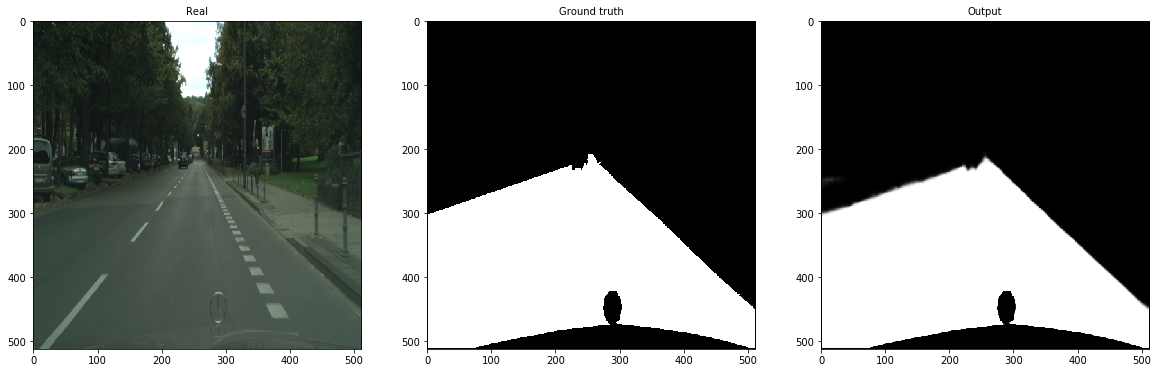

In [50]:
#Iterando para carregar novas imagens
img_real, _ = iter_real.next()
img_mask, _ = iter_mask.next()

with torch.no_grad():
    #Acertando dimensões para ficar na formatação necessária para o matplotlib
    single_img_real = img_real[0]
    single_img_mask = img_mask[0][0] #Grayscale

    single_img_real = single_img_real.permute(1,2,0)
    single_img_mask = single_img_mask.permute(0,1)

    #Gerando imagem pelo modelo a partir da imagem real
    img_real = img_real.to(device) #Passando para o mesmo device para não dar erro
    img_out = E_Net_model(img_real)

    single_img_out = img_out[0][0]
    single_img_out.permute(0,1)

    print('-------- Train Dataset --------')
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,20))
    
    ax0.imshow(single_img_real.to('cpu'))
    ax0.set_title('Real', fontsize=10)

    ax1.imshow(single_img_mask.to('cpu'), cmap='gray')
    ax1.set_title('Ground truth', fontsize=10)

    ax2.imshow(single_img_out.to('cpu').detach(), cmap='gray')
    ax2.set_title('Output', fontsize=10)

In [12]:
#Visualizando sobre o dataset de validação
#Criando iteradores para o data dateset de teste
iter_real_val = iter(dataloader_val_real)
iter_mask_val = iter(dataloader_val_mask)

					-------- Validation Dataset --------


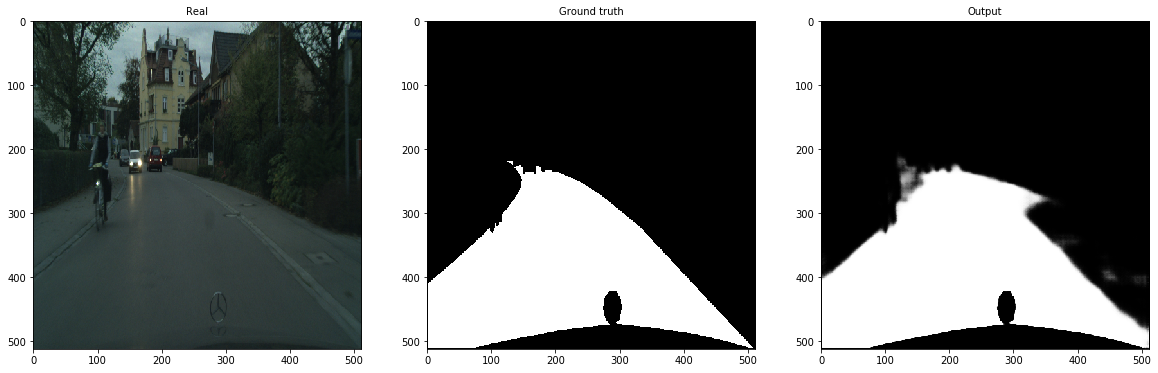

In [42]:
#Iterando para carregar novas imagens
img_real_val, _ = iter_real_val.next()
img_mask_val, _ = iter_mask_val.next()

img_real_val = img_real_val.to(device)
img_mask_val = img_mask_val.to(device)

with torch.no_grad():
    #Acertando dimensões para ficar na formatação necessária para o matplotlib
    single_img_real_val = img_real_val[0]
    single_img_mask_val = img_mask_val[0][0] #Grayscale

    single_img_real_val = single_img_real_val.permute(1,2,0)
    single_img_mask_val = single_img_mask_val.permute(0,1)

    #Gerando imagem pelo modelo a partir da imagem real
    img_real_val = img_real_val.to(device) #Passando para o mesmo device para não dar erro
    img_out_val = E_Net_model(img_real_val)

    single_img_out_val = img_out_val[0][0]
    single_img_out_val.permute(0,1)

    print('\t\t\t\t\t-------- Validation Dataset --------')
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,20))
    
    ax0.imshow(single_img_real_val.to('cpu'))
    ax0.set_title('Real', fontsize=10)

    ax1.imshow(single_img_mask_val.to('cpu'), cmap='gray')
    ax1.set_title('Ground truth', fontsize=10)

    ax2.imshow(single_img_out_val.to('cpu').detach(), cmap='gray')
    ax2.set_title('Output', fontsize=10)

## Métricas de validação

Antes de partir para a métricas é importande entender alguns termos. Considerando a análise para a classe de pixels brancos *road* como a nossa classe positiva (a que queremos prever) e a classe de *neutral*, pixels pretos, como a classe negativa :

- **Verdadeiro Positivo**: são os pixels brancos presentes na área de interseção (pixels brancos gerados que também estão presentes na máscara verdadeira)


- **Falso Positivo**: seria a área de pixels brancos presentes na máscara gerada, porém não presentes na máscara verdadeira, ou seja, falsos pixels brancos


- **Falso Negativo**: seria a área de pixels brancos presentes na máscara verdadeira, porém não presente na gerada, são falsos pixels pretos.


Com o intuito de validar nosso modelo será utilizado as seguintes métricas:

- **Precision**: $$ \frac{Verdadeiro \ Positivo}{Verdadeiro \ Positivo + Falso \ Positivo} $$ <br/>
Pode ser entendido como, dos pixels os quais o modelo determinou sendo de uma determinada classe (branco por exemplo), quais deles realmente pertence a essa classe 


- **Recall**: $$ \frac{Verdadeiro \ Positivo}{Verdadeiro \ Positivo + Falso \ Negativo} $$ <br/>
Pode ser entendido como, dos pixels que pertence a uma determinada classe, quais deles o modelo realmente acertou como sendo daquela classe

- IoU (*Intersection over Union*) :$$ \frac{Área \ de \ Interseção}{Área \ Verdadeira + Área \ Gerada - Área \ de \ Interseção }$$

[Aqui](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) é uma boa fonte para entender melhor sobre tal o IoU.

Text(0.5, 1.0, 'Intersecção das Máscaras')

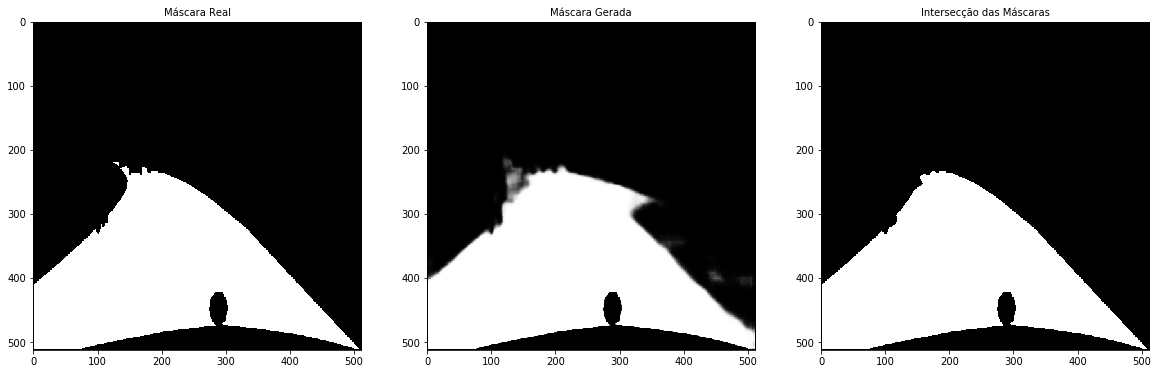

In [43]:
#Vamos gerar primeiro nossa imagem com a interseção de pixels brancos
#Para isso, como as imagens são compostas de 0s e 1s, só precisamos multiplicá-las
intersecao = single_img_mask_val * single_img_out_val

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,20))

intersecao = (intersecao>0.5).int()

ax0.imshow(single_img_mask_val.to('cpu'), cmap='gray')
ax0.set_title('Máscara Real', fontsize=10)

ax1.imshow(single_img_out_val.to('cpu').detach(), cmap='gray')
ax1.set_title('Máscara Gerada', fontsize=10)

ax2.imshow(intersecao.to('cpu'), cmap='gray')
ax2.set_title('Intersecção das Máscaras', fontsize=10)

Área Verdadeira:  75935
Área Gerada:  82573
Área Interseção / Verdadeiro Positivo:  75473
Falso Positivo:  6632
Falso Negativo:  462

Métricas:

IoU: 0.9089299692900584
Precision: 0.919225382132635
Recall: 0.9939158490814513


Text(0.5, 1.0, 'Falso Negativo')

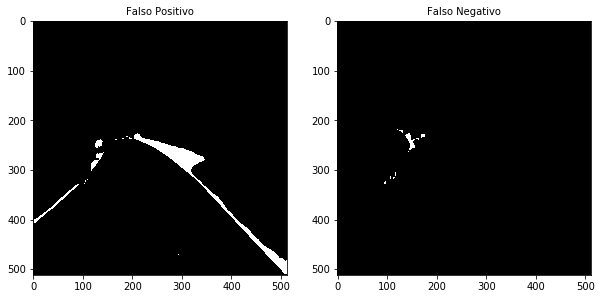

In [44]:
True_Area = int(torch.sum(single_img_mask_val))
Gen_Area = int(torch.sum(single_img_out_val))
Inter_Area = int(torch.sum(intersecao))
print("Área Verdadeira: ", True_Area)
print("Área Gerada: ", Gen_Area)
print("Área Interseção / Verdadeiro Positivo: ", Inter_Area)

IoU = Inter_Area/(Gen_Area+True_Area-Inter_Area)

FP_image = intersecao - single_img_out_val
FP_image = torch.abs(FP_image)
FP_image = (FP_image > 0.5).int()
FP = int(torch.sum(FP_image))
print("Falso Positivo: ", FP)

FN_image = intersecao - single_img_mask_val
FN_image = torch.abs(FN_image)
FN_image = (FN_image > 0.5).int()
FN = int(torch.sum(FN_image))
print("Falso Negativo: ", FN)

Precision = Inter_Area/(Inter_Area + FP)
Recall = Inter_Area/(Inter_Area + FN)

print("\nMétricas:\n\nIoU: {}\nPrecision: {}\nRecall: {}".format(IoU, Precision, Recall))

f, (ax0, ax1) = plt.subplots(1,2,figsize=(10,10))
    
ax0.imshow(FP_image.to('cpu'), cmap='gray')
ax0.set_title('Falso Positivo', fontsize=10)

ax1.imshow(FN_image.to('cpu'), cmap='gray')
ax1.set_title('Falso Negativo', fontsize=10)

## Algoritmo de teste
Vamos agora iterar sobre todo o dataset de teste aplicando tais métricas nas imagens a fim de observar o desempenho médio do modelo

In [52]:
#Criando iteradores para o data dateset de validação
iter_mask_val = iter(dataloader_val_mask)
iter_real_val = iter(dataloader_val_real)

IoU_Med = 0
Precision_med = 0
Recall_med = 0

print("Iniciando Teste ...\n")
with torch.no_grad(): #Não precisamos computar gradientes no teste
    for i in range(len(dataset_val_real)):
        #Carrego uma imagem do dataset
        
        img_real_val, _ = iter_real_val.next()
        img_mask_val, _ = iter_mask_val.next()
        
        #Tento passar para GPU
        img_real_val = img_real_val.to(device)
        img_mask_val = img_mask_val.to(device)
        #Gero a máscara a partir da imgem real
        img_out_val = E_Net_model(img_real_val)
        
        #Retiro dimensão 1 desnecessária
        single_img_mask_val = img_mask_val[0][0]
        single_img_out_val = img_out_val[0][0]
        
        #Gerando intersecção (verdadeiro positivo)
        intersecao = single_img_mask_val * single_img_out_val
        intersecao = (intersecao>0.5).int()
        
        #Calculando áreas de pixels brancos para calcular IoU
        True_Area = int(torch.sum(single_img_mask_val))
        Gen_Area = int(torch.sum(single_img_out_val))
        Inter_Area = int(torch.sum(intersecao))
        
        if (Gen_Area+True_Area-Inter_Area) == 0:
            IoU = 0
        else:
            IoU = Inter_Area/(Gen_Area+True_Area-Inter_Area)
        
        #Calculo do falso positivo
        FP_image = intersecao - single_img_out_val
        FP_image = torch.abs(FP_image)
        FP_image = (FP_image > 0.5).int()
        FP = int(torch.sum(FP_image))
        
        #Calculo do falso negativo
        FN_image = intersecao - single_img_mask_val
        FN_image = torch.abs(FN_image)
        FN_image = (FN_image > 0.5).int()
        FN = int(torch.sum(FN_image))
        
        #Calculo precision e recall
        if (Inter_Area + FP) == 0:
            Precision = 0
        else:
            Precision = Inter_Area/(Inter_Area + FP)
        
        if (Inter_Area + FN) == 0:
            Recall = 0
        else:
            Recall = Inter_Area/(Inter_Area + FN)
        
        Precision_med = Precision_med + Precision
        Recall_med = Recall_med + Recall
        IoU_Med = IoU_Med + IoU


IoU_Med = IoU_Med / len(dataset_val_real)
Precision_med = Precision_med / len(dataset_val_real)
Recall_med = Recall_med / len(dataset_val_real)

print("\nTeste terminado:\nIoU Med: {}\nPrecion Med: {}\nRecall Med: {}".format(
IoU_Med, Precision_med, Recall_med))
        

Iniciando Teste ...


Teste terminado:
IoU Med: 0.8727805272486273
Precion Med: 0.9009640596971007
Recall Med: 0.8986135848851711
